In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
# from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0 # Normalize pixel values to be between 0 and 1

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
from keras import datasets

In [ ]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
train_images.shape,train_labels.shape, val_images.shape,val_labels.shape

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

In [ ]:
model.fit(x_train, y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1875/1875 [==============================] - 4049s 2s/step - loss: 0.3202 - accuracy: 0.9216
Epoch 2/2
1875/1875 [==============================] - 3965s 2s/step - loss: 0.2048 - accuracy: 0.9538


In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [ ]:
import tensorflow as tf 
import numpy as np 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
x_test = tf.image.resize(x_test, [32,32]) # if we want to resize 


# one hot 
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
# y_test = tf.keras.utils.to_categorical(y_test , num_classes=10)


print(x_train.shape, y_train.shape)

(60000, 32, 32, 3) (60000, 10)


In [ ]:
predictions = model.predict(x_test)
y_preds = predictions.argmax(axis =1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       1.00      0.98      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.89      0.94       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.91      0.97      0.94       974
           9       0.95      0.98      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
print(y_preds)

[7 2 1 ... 4 5 6]


In [ ]:
print(y_test)

[7 2 1 ... 4 5 6]


In [ ]:
def accuracy(y_hat, y):
    
    assert(y_hat.size == y.size)
    count=0
    for i in range(y.size):
        if (y[i]==y_hat[i]):
            count = count + 1
    acc = count/y.size
    return acc
    pass

print(accuracy(y_preds,y_test))

0.973


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix


# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class_names = ['0', '1', '2', '3', '4', 
               '5', '6', '7', '8', '9']

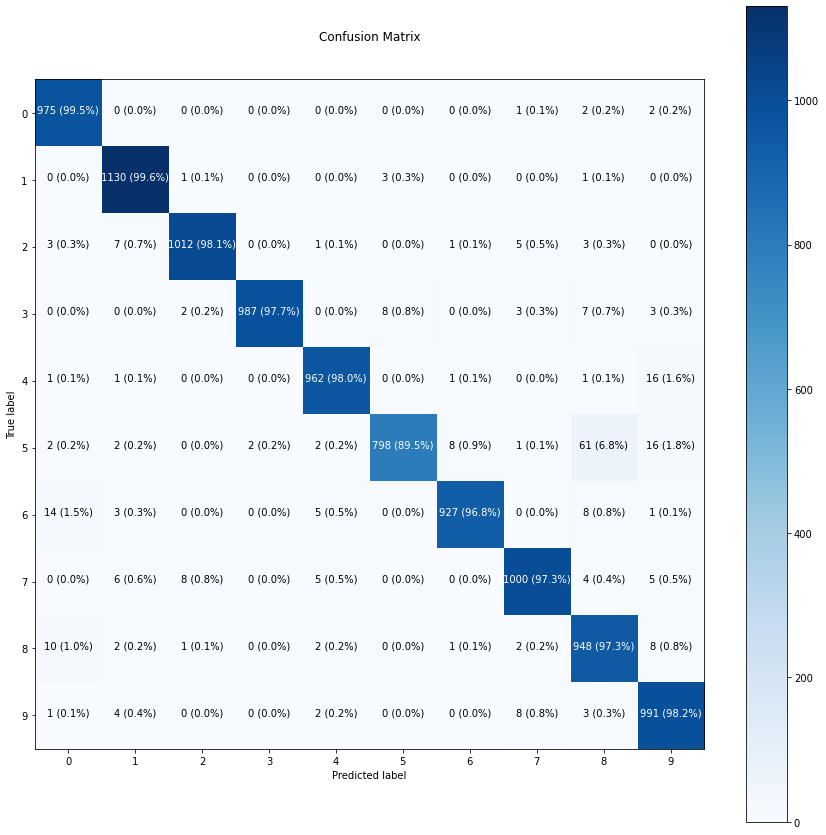

In [ ]:
make_confusion_matrix(y_true=y_test, 
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

y_test1 = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
y_preds1 = label_binarize(y_preds, classes=[0,1,2,3,4,5,6,7,8,9])



In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_preds1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_preds1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

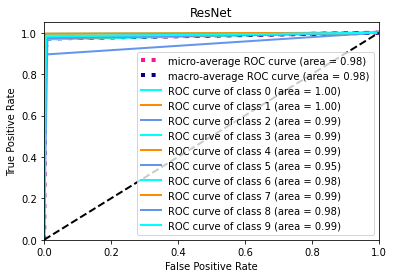

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
lw=2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 10

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(10), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet")
plt.legend(loc="lower right")
plt.show()